# NORTA
This is a homework implementation of the well-knwon algorithm to generation d-dimensional random vector with correlations. The NORTA or NORmal To Anything Algorithm can create this random vectors by giving just the d-marginal of each dimension. But it degenerates as the dimension grows.

The original paper can be found [here](https://pdfs.semanticscholar.org/8a45/34b1031d611876e2ee047ff5d2dc3757397c.pdf).

In [ ]:
import numpy as np
import scipy as sp
from scipy.stats import norm
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def gen_NORTA_from_rand(m,n,v,r):
    """
    weights \in [1,v]
    prices \in [r,v+r]
    """
    matriz = np.random.rand(m,n)
    R = np.corrcoef(matriz)
    print("Correlation Matriz:\n",R)
    L = np.linalg.cholesky(R) #lower
    W = np.random.normal(0, 1, (m,n))
    Z = np.dot(L,W)
    #print(np.shape(Z))
    X = np.empty([m, n])
    #print(np.shape(X))
    for i in range(n):
            X[0,i] = int(float(v-1)*norm.cdf(Z[0,i])+float(1.0))
            X[1,i] = int(float(v)*norm.cdf(Z[1,i])+float(r))
    #print(X)
    return X

In [ ]:
X = gen_NORTA_from_rand(2,1000,100,10)
plt.scatter(X[0,:],X[1,:])
plt.title("Plot of Dimension's relation")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [ ]:
def gen_instances_from_NORTA(m,n,R,v,r):
    """
    m: dimensiones
    n: número de muestras
    R: matriz de correlaciones deseada
    weights \in [1,v]
    prices \in [r,v+r]
    """
    L = np.linalg.cholesky(R) #lower
    W = np.random.normal(0, 1, (m,n))
    Z = np.dot(L,W)
    X = np.empty([m, n])
    #print(np.shape(X))
    for i in range(n):
            X[0,i] = int(float(v-1)*norm.cdf(Z[0,i])+float(1.0))
            X[1,i] = int(float(v)*norm.cdf(Z[1,i])+float(r))
    return X

In [ ]:
corr = 0.7
R = [[1, corr],[corr, 1]]
print("Correlation Matriz:\n",R)
Z = gen_instances_from_NORTA(2,1000,R,100,10)
plt.scatter(Z[0,:],Z[1,:])
plt.title("Plot of Dimension's relation")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [156]:
import numpy as np
from scipy.stats import norm, beta, expon, uniform, gamma, erlang

class Norta:
    """
    This class contains the NORmal To Anything (NORTA) algorithm to produce vector with correlations in the dimensions.
    
    Init:
    matrix M (mxn), wich has n-dimensions and m-observations per dimension.
    *args Marginal functions from which the dimension come from.
    If needed **kwargs will contain the parameter (by name) of the Marginal functions
    
    Methods:
    generate: Once initialize the parameters and functions, given the n-observation to generate, the method
    creates a matrix of mxn elementes, with identical Marginal distributions as the original described and with 
    the same correlation.
    """
    def __init__(self):
        self.contenedor = []
    
    def set_marginal(self, *args, **kwargs):
        if args[0] == 'normal':
            if ('mu' in kwargs) and ('sigma' in kwargs):
                self.contenedor.append({'function':norm,'mu':kwargs.get('mu'),'sigma':kwargs.get('sigma')})
                print("Function successfully added")
            else:
                print("Error when adding function to Norta")
                print("Remember that to add a normal function as arg and kwargs: set_marginal('normal',mu=,sigma=)")
        elif args[0] == 'beta':
            if len(kwargs) <= 2:
                if ('a' in kwargs) and ('b' in kwargs):
                    self.contenedor.append({'function':beta,'mu':kwargs.get('mu'),'sigma':kwargs.get('sigma')})
                    print("Function successfully added")
                else:
                    print("Error when adding function to Norta")
                    print("Remember that to add a beta function as arg and kwargs: set_marginal('beta',a=,b=)")
            else:
                if ('a' in kwargs) and ('b' in kwargs) and ('loc' in kwargs) and ('scale' in kwargs):
                    self.contenedor.append({'function':beta,'a':kwargs.get('a'),'b':kwargs.get('b'),
                                            'loc':kwargs.get('loc'),'scale':kwargs.get('scale') })
                    print("Function successfully added")
                else:
                    print("Error when adding function to Norta")
                    print("Remember that to add a beta function as arg and kwargs: set_marginal('beta',a=,b=,loc=,scale=)")
        elif args[0] == 'expon':
            if ('lambda' in kwargs):
                self.contenedor.append({'function':expon,'lambda':kwargs.get('lambda')})
                print("Function successfully added")
            else:
                print("Error when adding function to Norta")
                print("Remember that to add a exponencial function as arg and kwargs: set_marginal('expon',lambda=)")
        elif args[0] == 'uniform':
            if ('a' in kwargs) and ('b' in kwargs):
                self.contenedor.append({'function':uniform,'a':kwargs.get('a'),'b':kwargs.get('b')})
                print("Function successfully added")
            else:
                print("Error when adding function to Norta")
                print("Remember that to add a uniform function as arg and kwargs: set_marginal('uniform',a=,b=")
        elif args[0] == 'gamma':
            pass
        elif args[0] == 'erlang':
            pass
        elif args[0] == 'poisson':
            if ('a' in kwargs) and ('b' in kwargs):
                self.contenedor.append({'function':poisson,'a':kwargs.get('a'),'b':kwargs.get('b')})
                print("Function successfully added")
            else:
                print("Error when adding function to Norta")
                print("Remember that to add a poisson function as arg and kwargs: set_marginal('poisson',a=,b=")
        else:
            print("Function does not exist in this implementation")
        
    def delete_marginal(self,*args):
        """
        Pronto
        """
        pass
    
    def set_data(self,data):
        """
        Recieves for now just a numpy array, that has to be the same dimension as the functions loaded so far
        """
        m,n = np.shape(data)
        if len(self.contenedor) != n:
            raise Exception('Not maching number in functions %d and dimension %d in Matrix' 
                            %(len(self.contenedor),m))
        else:
            self._generate_correlation_matrix(data,porcentaje=0.1,muestra=10000)
            self._generate_L()
    
    def _generate_correlation_matrix(self,data,porcentaje = 0.1,muestra = 10000):
        """
        Genera la matrix de correlaciones para la 
        """
        m,n = np.shape(data)
        self.C = np.empty([n,n])
        np.fill_diagonal(self.C, 1)
        for dim1 in range(n):
            for dim2 in range(n):
                if dim1 < dim2 and dim1 != dim2:
                    W1 = np.random.normal(0, 1, (muestra))
                    W2 = np.random.normal(0, 1, (muestra))
                    rho = np.corrcoef(data[:,dim1],data[:,dim2])[0,1]
                    if rho < 0:
                        l = -1
                        u = 0
                    else:
                        l = 0
                        u = 1
                    r = rho
                    rho_estimado = self._rho_function(r,W1,W2,muestra,dim1,dim2)
                    while np.absolute(rho_estimado - rho) > porcentaje*np.absolute(rho):
                        if rho_estimado > rho:
                            u = r
                        else:
                            l = r
                        r = (l+u)/2
                        rho_estimado = self._rho_function(r,W1,W2,muestra,dim1,dim2)
                    self.C[dim1,dim2] = rho_estimado
                    self.C[dim2,dim1] = rho_estimado
        print(self.C)
        
    def _rho_function(self,rho,W1,W2,m,dim1,dim2):
        z = np.empty([2,m])
        z[0,:] = np.copy(W1)
        z[1,:] = rho*z[0,:] + (np.sqrt(1-np.power(rho,2)))*W2
        x = np.empty([2,m])
        for func in [self.contenedor[dim1]['function']]:
            x[0,:] = func.ppf(q=norm.cdf(z[0,:]),loc=self.contenedor[dim1]['mu'],
                              scale=self.contenedor[dim1]['sigma'])
        for func in [self.contenedor[dim2]['function']]:
            x[1,:] = func.ppf(q=norm.cdf(z[1,:]),loc=self.contenedor[dim2]['a'],
                              scale=self.contenedor[dim2]['b'])
        numerador = np.sum((x[0,:]-np.mean(x[0,:]))*(x[1,:]-np.mean(x[1,:])))
        denominador = np.sqrt( np.sum(np.power(x[0,:]-np.mean(x[0,:]),2))*
                          np.sum(np.power(x[1,:]-np.mean(x[1,:]),2)) )
        rho_estimado = numerador/denominador
        return rho_estimado
        
    def set_and_fit_data(self,data):
        """
        Recibe la data, calcula cual es la distribución que mejor queda para cada dimensión, y luego genera el
        modelo.
        """
        pass
    
    def _generate_L(self):
        self.L = np.linalg.cholesky(self.C)
    
    def generate_sample(self, m=1):
        n = len(self.contenedor)
        W = np.random.normal(0, 1, (n,m))
        Z = np.dot(self.L,W)
        if n==1:
            Z = Z.reshape((-1, 1)) 
        else:
            Z = Z.T
        X = np.empty([m, n])
        for dimension in range(n):
            for func in [self.contenedor[dimension]['function']]:
                if func == norm:
                    X[:,dimension] = func.ppf(q=norm.cdf(Z[:,dimension]),loc=self.contenedor[dimension]['mu'],
                                  scale=self.contenedor[dimension]['sigma'])
                elif func == uniform:
                    X[:,dimension] = func.ppf(q=norm.cdf(Z[:,dimension]),loc=self.contenedor[dimension]['a'],
                                  scale=self.contenedor[dimension]['b'])
                else:
                    print("Function does not exist in this implementation")
        return X

In [161]:
np.random.seed(1994)
dim1 = np.random.normal(15,1,10000)
dim2 = np.random.uniform(10,20,10000)
M = np.column_stack((dim1,dim2))

#Llamamos a la clase
Prueba = Norta()
Prueba.set_marginal('normal', mu=15,sigma=1)
Prueba.set_marginal('uniform', a=10, b=20)
Prueba.set_data(M)
sample_data = Prueba.generate_sample(10000)
#print(sample_data)

normal
Function successfully added

uniform
Function successfully added

[[1.00000000e+00 8.09846136e-04]
 [8.09846136e-04 1.00000000e+00]]


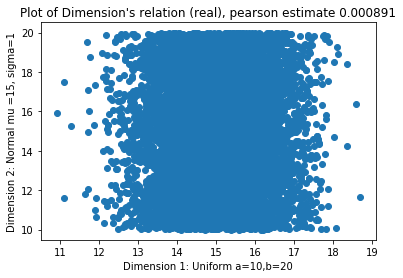

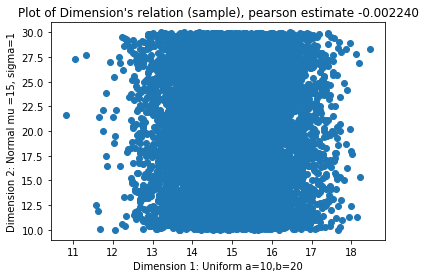

In [162]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(dim1,dim2)
plt.title("Plot of Dimension's relation (real), pearson estimate %f" %(np.corrcoef(dim1,dim2)[0,1]))
plt.xlabel("Dimension 1: Uniform a=10,b=20")
plt.ylabel("Dimension 2: Normal mu =15, sigma=1")
plt.show()
plt.scatter(sample_data[:,0],sample_data[:,1])
plt.title("Plot of Dimension's relation (sample), pearson estimate %f" %
          (np.corrcoef(sample_data[:,0],sample_data[:,1])[0,1]))
plt.xlabel("Dimension 1: Uniform a=10,b=20")
plt.ylabel("Dimension 2: Normal mu =15, sigma=1")
plt.show()